# Explore here

In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima

from sklearn.model_selection import train_test_split

import warnings

In [24]:
# reading and saving the data
url = 'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
rawdata = pd.read_csv(url)
rawdata.to_csv('../data/raw/sales_raw.csv')

In [25]:
rawdata.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


##### We can observe that tensor = Days (YYYY-MM-DD) is the minimum time unit of the data (given that there are no entries on the same day)

In [26]:
rawdata['date'] = pd.to_datetime(rawdata['date']).dt.floor("d")
rawdata.head(10)

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633
5,2022-09-08,60.081865
6,2022-09-09,68.466704
7,2022-09-10,67.765106
8,2022-09-11,70.512261
9,2022-09-12,74.656453


In [27]:
rawdata = rawdata.set_index("date")
df = rawdata
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


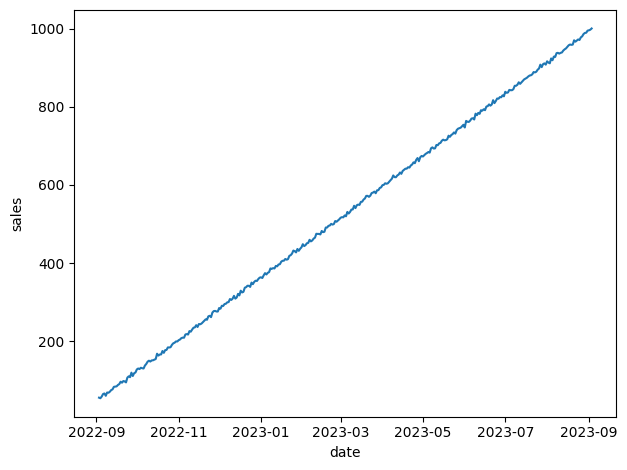

In [29]:
sns.lineplot(x=df.index, y= df['sales']) # type : ignore
plt.tight_layout()
plt.show()

In [30]:
sales = df['sales']

sales.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

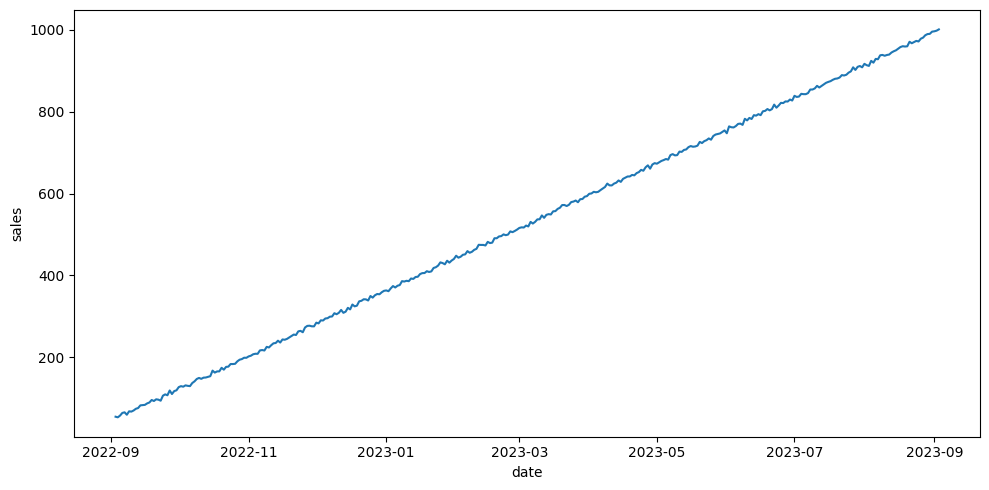

In [33]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales)

plt.tight_layout()

plt.show()

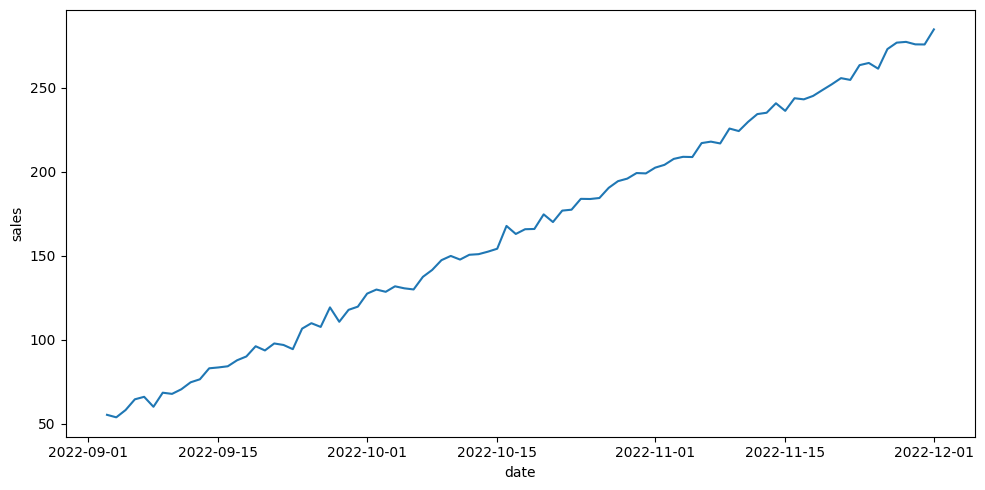

In [43]:
start_date = "2022-09"
end_date = "2022-12"
#greater than the start date and smaller than the end date
mask = (sales.index> start_date) & (sales.index <= end_date)

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales.loc[mask])

plt.tight_layout()

plt.show()


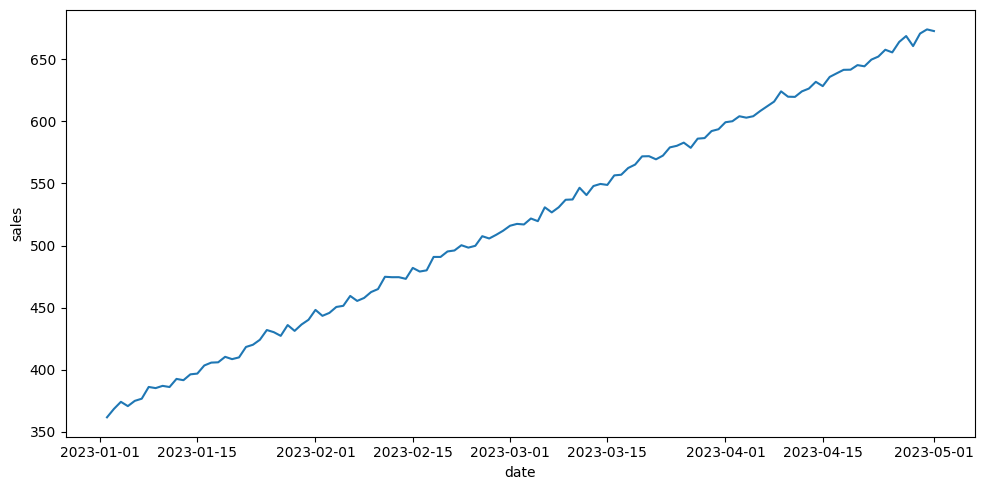

In [58]:
start_date = "2023-01"
end_date = "2023-05"

# selecciono periodo de observación
periodo = (sales.index> start_date) & (sales.index <= end_date)

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = sales.loc[periodo])

plt.tight_layout()

plt.show()

Tensor: días (secs?)    

Tendencia: Ascendente

Estacionaria: Sí 

Variabilidad/ruido: Sí


In [62]:
decomp = seasonal_decompose(sales, period = 52) 
decomp

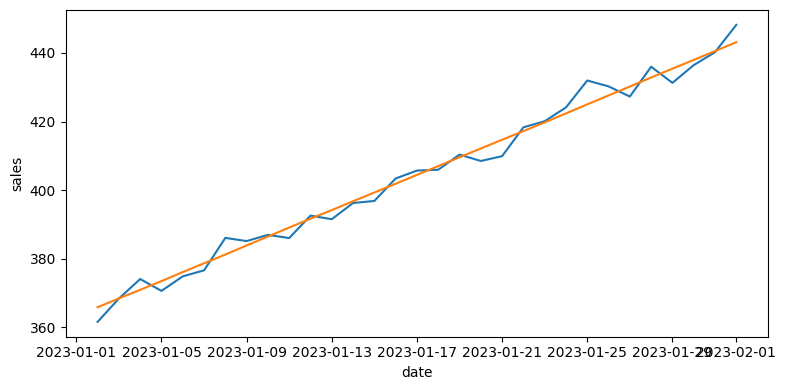

In [64]:
trend = decomp.trend

# defino periodo
start_date = "2023-01"
end_date = "2023-02"
periodo = (sales.index> start_date) & (sales.index <= end_date)

# plot
fig, axis = plt.subplots(figsize = (8, 4))
sns.lineplot(data = sales[periodo])
sns.lineplot(data = trend[periodo])
plt.tight_layout()
plt.show()

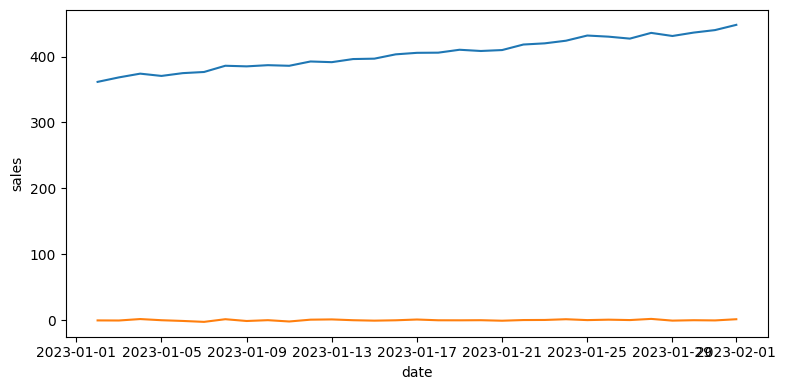

In [67]:
season = decomp.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales[periodo])
sns.lineplot(data = season[periodo])

plt.tight_layout()

plt.show()


### claramente no hay estacionalidad

In [68]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [70]:
test_stationarity(sales)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

In [75]:
print(sales)

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64


In [76]:
# Diferenciar la serie para remover tendencia
sales_diff = sales.diff().dropna()

sales_diff



date
2022-09-04   -1.488946
2022-09-05    4.338482
2022-09-06    6.389205
2022-09-07    1.482734
2022-09-08   -5.931768
                ...   
2023-08-30    0.518681
2023-08-31    5.386972
2023-09-01    0.827090
2023-09-02    1.535798
2023-09-03    3.132571
Name: sales, Length: 365, dtype: float64

In [77]:
test_stationarity(sales_diff)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

### la serie es absolutamente estacionaria y no estacional (el p value para la prueba DF de la serie diff es casi 0)

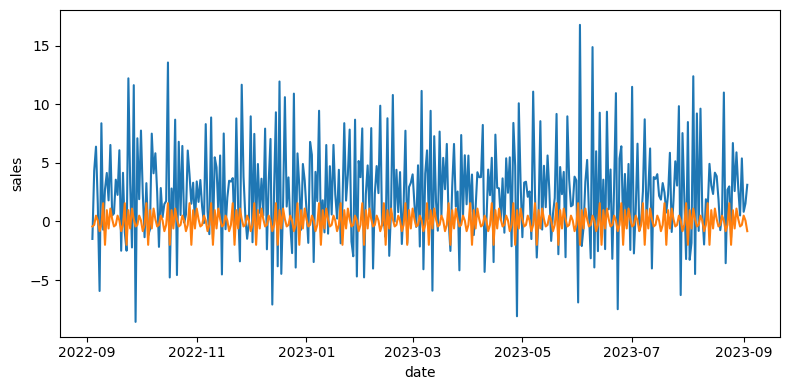

In [78]:
sales_diff_decomp = seasonal_decompose(sales_diff, period=12)

sales_diff_season = sales_diff_decomp.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales_diff)
sns.lineplot(data = sales_diff_season)

plt.tight_layout()

plt.show()

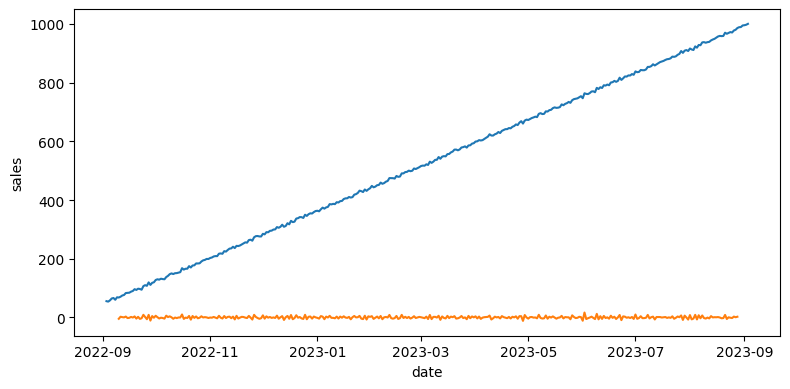

In [82]:
residual = sales_diff_decomp.resid

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

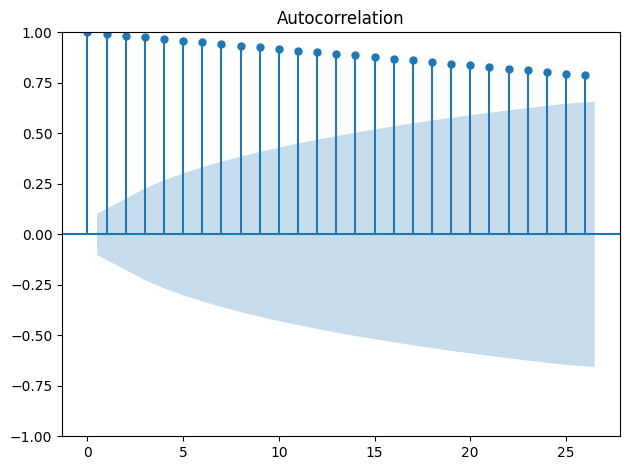

In [83]:
plot_acf(sales)

plt.tight_layout()
plt.show()

In [84]:
model = auto_arima(sales, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.128, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.646, Time=1.18 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.54 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.36 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.435, Time=1.07 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.02 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.29 sec
 ARIMA(1,1,1)(1,0,0)[12] inte

In [85]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Wed, 24 Jul 2024   AIC                           1839.552
Time:                        20:31:41   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
forecast = model.predict(12)    
forecast

2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206408
2023-09-15    1030.804239
Freq: D, dtype: float64

In [88]:
sales.tail(10)

date
2023-08-25     971.046134
2023-08-26     977.744160
2023-08-27     980.341854
2023-08-28     986.244637
2023-08-29     989.081673
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, dtype: float64

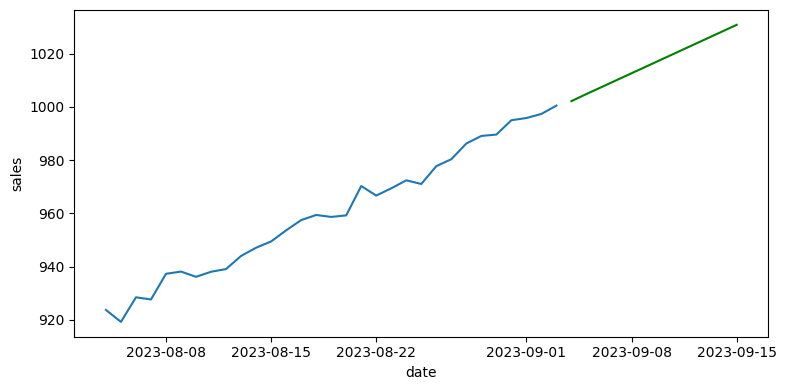

In [90]:
# defino periodo
start_date = "2023-08-03"
end_date = "2023-09-03"
periodo = (sales.index> start_date) & (sales.index <= end_date)

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = sales[periodo])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [96]:
X = sales

train, test = train_test_split(X, test_size=0.2, random_state=21)

train

date
2023-04-04    602.984304
2023-06-14    790.037113
2023-02-26    505.671963
2022-12-14    311.667997
2023-02-02    443.382174
                 ...    
2023-01-01    363.458044
2022-10-21    170.089813
2023-05-21    723.145751
2023-07-12    858.674317
2023-03-29    586.553031
Name: sales, Length: 292, dtype: float64

In [97]:
test

date
2022-12-05    294.984712
2023-02-14    473.173009
2022-09-23     94.395825
2023-03-09    536.868824
2022-11-08    216.890227
                 ...    
2023-07-14    866.105635
2022-09-27    119.275017
2023-05-17    714.124578
2022-09-07     66.013633
2023-02-05    451.434223
Name: sales, Length: 74, dtype: float64

In [99]:
arima_model = auto_arima(train, seasonal = False, trace = True, m= 12)

arima_model.summary()

c:\Users\34616\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4563.179, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4289.898, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4440.255, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4208.208, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4187.613, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4177.832, Time=0.06 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4161.755, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4121.180, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4121.481, Time=0.07 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=4123.189, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4123.490, Time=0.08 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -2053.590
Date:                Wed, 24 Jul 2024   AIC                           4121.180
Time:                        20:38:03   BIC                           4146.918
Sample:                             0   HQIC                          4131.490
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    434.1492     69.584      6.239      0.000     297.767     570.532
ar.L1         -0.0078      0.061     -0.127      0.899      -0.128       0.112
ar.L2          0.1010      0.061      1.661      0.097      -0.018       0.220
ar.L3          0.0009      0.058      0.016      0.987      -0.113       0.115
ar.L4         -0.0052      0.056     -0.092      0.927      -0.116       0.105
ar.L5          0.0899      0.061      1.486      0.137      -0.029       0.209
sigma2      7.599e+04      1e+04      7.570      0.000    5.63e+04    9.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.02
Prob(H) (two-sided):                  0.81   Kurtosis:                         1.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
y_pred = arima_model.predict(test.index)

TypeError: n_periods must be an int